In [2]:
# notebooks/logistic_baseline.ipynb

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
# Set data path (adjust to your structure)
data_dir = "../../inteldata/seg_train/seg_train/"  # or the correct relative path

# Parameters
img_size = (64, 64)

# Load and preprocess images
def load_images(data_dir, img_size):
    X = []
    y = []
    class_names = os.listdir(data_dir) # List of all subdirectories

    #Go through every subdirectory
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name) #Go into the subdirectory 
        if not os.path.isdir(class_path):
            continue

        #Go through all image files of the subdirectory
        for img_file in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
            try:
                img_path = os.path.join(class_path, img_file) #Go into the specific image file path

                # return rgb image object from path 
                
                img = Image.open(img_path).convert('RGB')
                #resizing the image
                if img.size != img_size:
                    img = img.resize(img_size)
                #Flatten out the image into (img x img) * 3 1D array
                img_array = np.array(img).flatten()
                #Normalize the pixel values between [0,1]
                img_array = img_array / 255.0

                X.append(img_array)
                y.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")
    
    return np.array(X), np.array(y)



Loading sea: 100%|████████████████████████| 2274/2274 [00:01<00:00, 1214.25it/s]


Starting grid search...
Best score: 0.5329020888419004
Best parameters: {'batch_size': 64, 'learning_rate': 0.0001, 'model__reg_param': 0.01, 'model__reg_type': 'l2', 'momentum': 0.9}
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.5138 - loss: 1.3569
Final model test accuracy: 0.5319
Final Model Test Loss: 1.3464


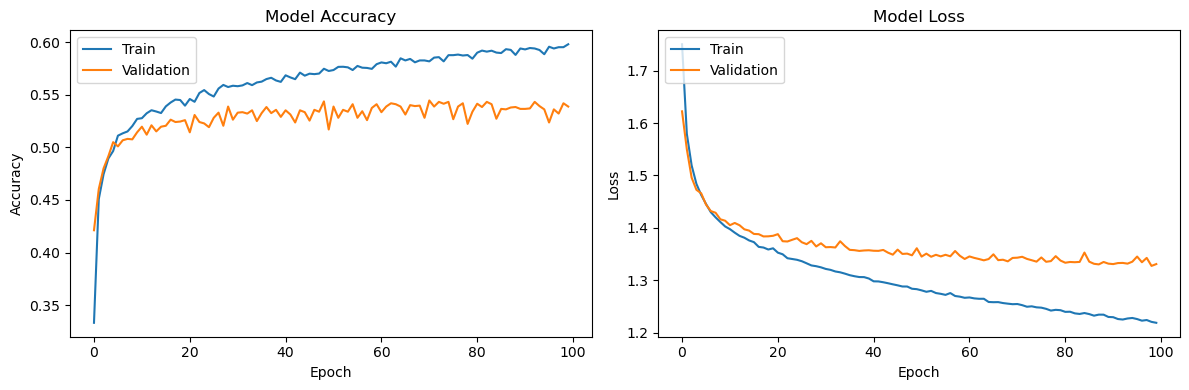

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier  # Updated wrapper

# Load and preprocess images
X, y = load_images(data_dir, img_size)

# Encode labels to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#get # of classes
num_classes = len(label_encoder.classes_)

# Split data: 20% test, 64% train, 16% validation
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


def create_model(reg_type='l2', reg_param=0.01,learning_rate=0.01, momentum=0.0):
    model = Sequential() #enable model that can add layers
    if reg_type == 'l1':
        regularizer = regularizers.L1(reg_param)
    else:  # l2
        regularizer = regularizers.L2(reg_param)
    #Input shape
    input_shape = img_size[0] * img_size[1] * 3
    #Using SGD as our optimizer for training
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

    #dense: fully connected layer
    
    model.add(Input(shape=(input_shape,)))
    #create output layer (6 labels)  using softmax activation
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer=regularizer))

    #Configures your model for training (how it will learn) stating the optimization algorithm, loss function we want to minize, metrics to store and report performance
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


#Wrapper object so it can be compatible to use with gridserachcv
# takes in create model function and spits out another function doing the training step with those parameters
model = KerasClassifier(
    model=create_model,
    learning_rate=0.01,
    momentum=0.0,
    epochs=50,  #define epochs of trianing during grid serach

    batch_size=32,
    verbose=0
)
# Define grid search parameters (SGD only)
#Bunch of random combos of parameters are used to trian a model and see which one performs best
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'model__reg_type': ['l1', 'l2'],
    'model__reg_param': [0.01, 0.1],
    'momentum': [0.0, 0.5, 0.9],
    'batch_size': [16, 32, 64]
}

# Set up gridsearch
# Does 3 fold cross validation on every combination of parameters

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=0
)

# Perform grid search
#trains many models
print("Starting grid search...")
grid_result = grid.fit(X_train, y_train_cat)

# Show best results
print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_}")
best_params = grid_result.best_params_

# Creating the best model with the best parameters we have obtained from GridSearch
# our final tuned model
final_model = create_model(
    reg_type=best_params['model__reg_type'],
    reg_param=best_params['model__reg_param'],
    learning_rate=best_params['learning_rate'],
    momentum=best_params['momentum']
)

"""
Trains the final model with its best parameters for X epochs and reports the training and validation loss

"""
history = final_model.fit(
    X_train,
    y_train_cat,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val_cat),
    verbose=0
)

# Report the accuracy and loss of the model after evaluating it on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Final model test accuracy: {test_accuracy:.4f}")
print(f"Final Model Test Loss: {test_loss:.4f}")

#plotting the accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


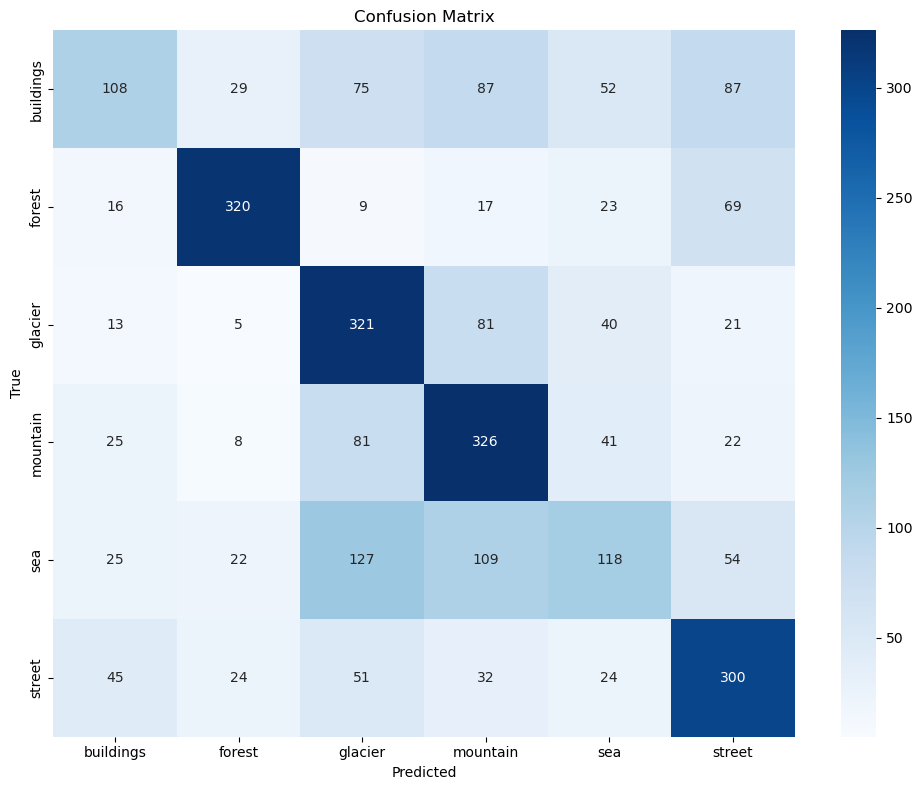


Classification Report:
              precision    recall  f1-score   support

   buildings       0.47      0.25      0.32       438
      forest       0.78      0.70      0.74       454
     glacier       0.48      0.67      0.56       481
    mountain       0.50      0.65      0.56       503
         sea       0.40      0.26      0.31       455
      street       0.54      0.63      0.58       476

    accuracy                           0.53      2807
   macro avg       0.53      0.53      0.51      2807
weighted avg       0.53      0.53      0.52      2807



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
y_pred_prob = final_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Get class names (for better labeling)
class_names = label_encoder.classes_

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Step 5: Print classification report for additional metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [17]:

model_acc = test_accuracy * 100
print(f"Final model test accuracy: {model_acc:.0f}%")




Final model test accuracy: 53%
